In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import joblib

from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import roc_curve, roc_auc_score

seed = 1234
np.random.seed(seed)

In [18]:
synergy = pd.read_csv('13data.csv')

In [19]:
y = np.array(synergy[['t1_win']]).ravel()
X = synergy.drop(['t1_win'], axis = 1)
X = X.to_numpy()

X_train, X_remaining, y_train, y_remaining = train_test_split(X, y, test_size=0.3, random_state=seed)
X_val, X_test, y_val, y_test = train_test_split(X_remaining, y_remaining, test_size=0.5, random_state=seed)
print("Train:", X_train.shape)
print("Val:", X_val.shape)
print("Test:", X_test.shape)

Train: (25629, 12)
Val: (5492, 12)
Test: (5492, 12)


## Majority Class

In [4]:
mj = DummyClassifier(strategy="most_frequent").fit(X_train, y_train)

print(mj)
print("Final test acc:", mj.score(X_test, y_test))

DummyClassifier(strategy='most_frequent')
Final test acc: 0.5025491624180627


## Logistics Regression

In [5]:
lr = LogisticRegression(
    penalty='l1', solver='saga', max_iter=130, random_state=seed
).fit(X_train, y_train)

print(lr)
print(lr.score(X_test, y_test))

LogisticRegression(max_iter=130, penalty='l1', random_state=1234, solver='saga')
0.7199563000728332


In [6]:
print(lr.coef_)
print(lr.intercept_)

[[-10.99426185 -10.26463961 -11.05715048 -11.83841074 -10.74156349
   10.79669624  12.70434262  11.77177134  11.81970406  12.56962499
    2.06732773  -2.09815369]]
[-2.41335727]


## Decision Tree Classifier

In [7]:
max_depth = [2, 5, 7, 10, 20]
dt_models = []
dt_train_acc = []
dt_val_acc = []

for i in max_depth:
    dt = DecisionTreeClassifier(max_depth=i, random_state=seed)
    dt.fit(X_train, y_train)
    dt_models.append(dt)
    dt_val_acc.append(dt.score(X_val, y_val))
    dt_train_acc.append(dt.score(X_train, y_train))

idx = np.argmax(dt_val_acc)  # index of the model with the highest validation accuracy
dt = dt_models[idx]
test_acc = dt.score(X_test, y_test)


print("Train acc:", dt_train_acc)
print("Val acc:", dt_val_acc)
print("Best model index:", idx)
print("Details:", dt)
print("Final test acc:", test_acc)

Train acc: [0.6634281478013189, 0.7020172460884154, 0.7140348823598267, 0.7602715673650943, 0.9836513324749308]
Val acc: [0.657319737800437, 0.6961034231609614, 0.6882738528769119, 0.6806263656227239, 0.6261835396941005]
Best model index: 1
Details: DecisionTreeClassifier(max_depth=5, random_state=1234)
Final test acc: 0.6804442825928624


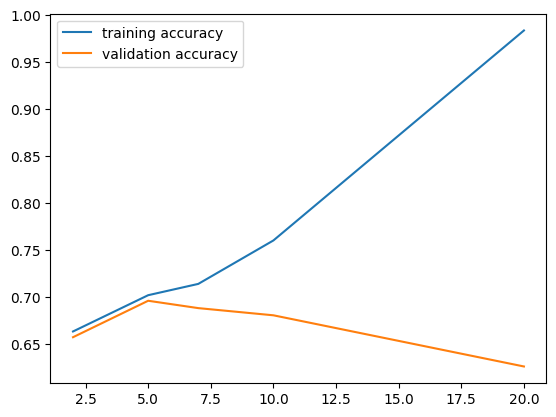

In [8]:
fig, ax = plt.subplots()
ax.plot(max_depth, dt_train_acc, label = 'training accuracy')
ax.plot(max_depth, dt_val_acc, label = 'validation accuracy')
ax.legend()

plt.show()

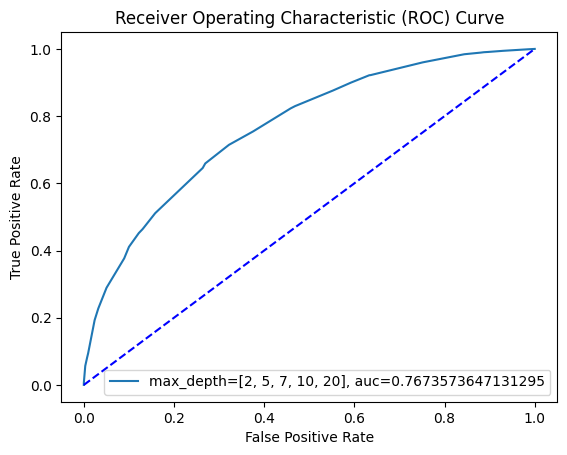

In [9]:
# best dt is defined above

# Get the predicted probabilities and keep probabilities for the positive outcome only
probs = dt.predict_proba(X_val)[:, 1]

# Compute the ROC curve
fpr, tpr, thresholds = roc_curve(y_val, probs)

# Compute Area Under the Curve (AUC)
roc_auc = roc_auc_score(y_val, probs)

# Plot ROC curve
plt.plot(fpr, tpr, label=f'max_depth={max_depth}, auc={roc_auc}')
plt.plot([0, 1], [0, 1], color='blue', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()


## Random Forest Classifer

In [10]:
n_est = [50, 100, 200, 500, 1000]
rf_models = []
rf_train_acc = []
rf_val_acc = []

for i in n_est:
    rfc = RandomForestClassifier(n_estimators= i, max_depth=5, random_state=seed)
    rfc.fit(X_train, y_train)
    rf_models.append(rfc)
    rf_val_acc.append(rfc.score(X_val, y_val))
    rf_train_acc.append(rfc.score(X_train, y_train))

idx = np.argmax(rf_val_acc)
rf = rf_models[idx]
test_acc = rf.score(X_test, y_test)

print("Train acc:", rf_train_acc)
print("Val acc:", rf_val_acc)
print("Best model index:", idx)
print("Details:", rf)
print("Final test acc:", test_acc)

Train acc: [0.7134886261656717, 0.7127862967731866, 0.7142299738577392, 0.7126692418744391, 0.7139568457606618]
Val acc: [0.7019300801165331, 0.7012017479970867, 0.7026584122359796, 0.7044792425345958, 0.7055717407137655]
Best model index: 4
Details: RandomForestClassifier(max_depth=5, n_estimators=1000, random_state=1234)
Final test acc: 0.698652585579024


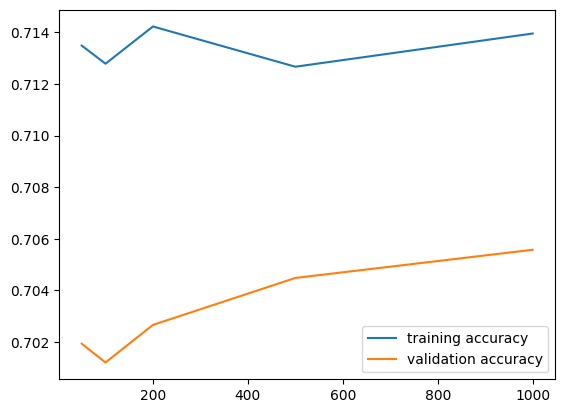

In [11]:
fig, ax = plt.subplots()
ax.plot(n_est, rf_train_acc, label = 'training accuracy')
ax.plot(n_est, rf_val_acc , label = 'validation accuracy')
ax.legend()

plt.show()

## MLP Classifier

In [20]:
hidden_layers = [(88,),(88, 88)]
activation = ['identity', 'logistic', 'tanh']
mlp_models = []
mlp_val_acc = []


for i in activation:
    tra_acc = i + '_tra_acc'
    val_acc = i + '_val_acc'
    for j in hidden_layers:
        mlp = MLPClassifier(hidden_layer_sizes= j, activation=i, random_state=seed)
        mlp.fit(X_train, y_train)
        mlp_val_acc.append(mlp.score(X_val, y_val))
        mlp_models.append(mlp)

idx = np.argmax(mlp_val_acc)
mlp = mlp_models[idx]
joblib.dump(mlp, 'mlp.joblib')

/shared-libs/python3.9/py/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


['mlp.joblib']

In [22]:
mlp_val_acc = []

for model in mlp_models:
    score = model.score(X_val, y_val)
    mlp_val_acc.append(score)


idx = np.argmax(mlp_val_acc)
mlp = joblib.load("mlp.joblib")
test_acc = mlp.score(X_test, y_test)

print("Best mlp model index:", idx)
print("Details:", mlp)
print("Final test acc:", test_acc)

Best mlp model index: 3
Details: MLPClassifier(activation='logistic', hidden_layer_sizes=(88, 88),
              random_state=1234)
Final test acc: 0.7177713037144938


In [14]:
print("Majority class test acc:", mj.score(X_test, y_test))
print("Logistic regression test acc:", lr.score(X_test, y_test))
print("Decision tree test acc:", dt.score(X_test, y_test))
print("Random forest test acc:", rf.score(X_test, y_test))
print("Multi-layer perceptron test acc:", mlp.score(X_test, y_test))

Majority class test acc: 0.5025491624180627
Logistic regression test acc: 0.7199563000728332
Decision tree test acc: 0.6804442825928624
Random forest test acc: 0.698652585579024
Multi-layer perceptron test acc: 0.7177713037144938


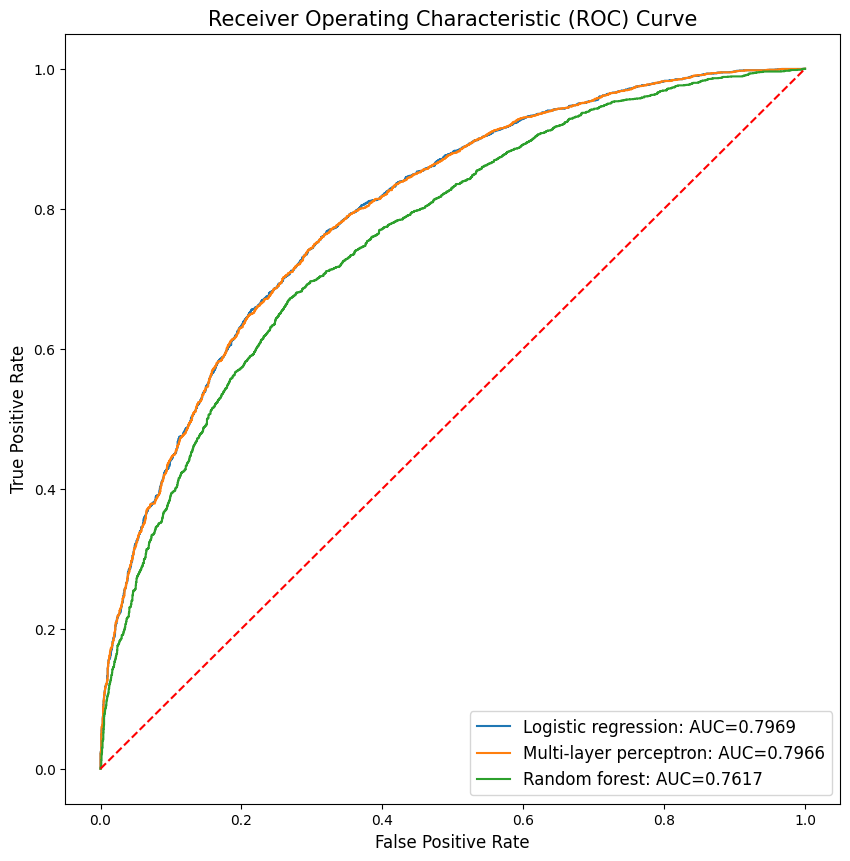

In [15]:
plt.figure(figsize=(10, 10))

# Majority class
# y_pred_proba = mj.predict_proba(X_test)[:,1]
# fpr, tpr, _ = roc_curve(y_test,  y_pred_proba)
# auc = roc_auc_score(y_test, y_pred_proba)
# plt.plot(fpr,tpr,label="Majority class: AUC="+str(round(auc, 4)))

# Logistic Regression
y_pred_proba = lr.predict_proba(X_test)[:,1]
fpr, tpr, _ = roc_curve(y_test,  y_pred_proba)
auc = roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="Logistic regression: AUC="+str(round(auc, 4)))

# Multi-layer perceptron
y_pred_proba =mlp.predict_proba(X_test)[:,1]
fpr, tpr, _ = roc_curve(y_test,  y_pred_proba)
auc = roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="Multi-layer perceptron: AUC="+str(round(auc, 4)))

# Random forest
y_pred_proba =rf.predict_proba(X_test)[:,1]
fpr, tpr, _ = roc_curve(y_test,  y_pred_proba)
auc = roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="Random forest: AUC="+str(round(auc, 4)))

# Decision tree
# y_pred_proba = dt.predict_proba(X_test)[:,1]
# fpr, tpr, _ = roc_curve(y_test,  y_pred_proba)
# auc = roc_auc_score(y_test, y_pred_proba)
# plt.plot(fpr,tpr,label="Decision tree: AUC="+str(round(auc, 4)))


plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.ylabel('True Positive Rate', size=12)
plt.xlabel('False Positive Rate', size=12)
plt.title('Receiver Operating Characteristic (ROC) Curve', size=15)
plt.legend(loc=4, fontsize=12)
plt.show()

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=e55512df-58ef-402e-8f63-17a773fe09fc' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>